# 1st Tutorial: Wavelets for Multiscale Image Processing

This content is largely based on [Gabriel Peyré's Numerical Tours](https://github.com/gpeyre/numerical-tours) 🤗


## Building Intuitions

In the first part, we get an intuition of what wavelets can do for Image compression, we will compare: 

* Compressing images by averaging on squares; 
* Keeping the low-frequency Fourier coefficients; 
* Keeping the largest Wavelet coefficients.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
import pywt # to compute wavelet transforms

In [2]:
def preprocess(f,n):
    """
    Preprocess a single Image by resizing to a square and normalizing 
    it in range [0,1]
    
    ---
    Inputs
    
    - f: PIL Image 
    - n: image width and height 
    
    Outputs: 
    - f: Image with values in range [0,1]
    """
    n0 = np.min( f.size )
    f = f.crop((0, 0, n0, n0))
    f = f.resize((n, n))
    f = np.array(f)
    f = np.clip(f / np.max(f.flatten()), 0,1)
    return f

Load an image from the internet. The image has range of value [0,1].

In [3]:
from urllib.request import urlopen
import io

n = 512 # target size

# Download an image from wikimedia
file_adress = 'https://upload.wikimedia.org/wikipedia/commons/thumb/c/c7/Tabby_cat_with_blue_eyes-3336579.jpg/639px-Tabby_cat_with_blue_eyes-3336579.jpg'
fd = urlopen(file_adress)

# Open and preprocess the image
image_file = io.BytesIO(fd.read())
f = Image.open(image_file)
f = preprocess( f, n )

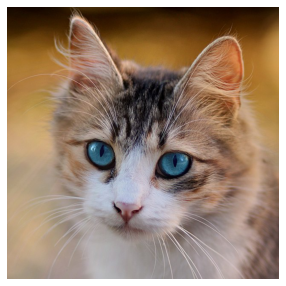

In [4]:
# Show the image
plt.rcParams['figure.figsize'] = [8, 5]
plt.imshow(f)
plt.axis('off');

In [5]:
def approx_pixels(f,r):
    """
    Approximate Image by interpolating pixels
    
    ---
    Inputs: 
    
    - f : PIL Image
    - r : compression ratio (smaller than 1) 
    
    Outputs: 
    
    - f : compressed image
    
    """
    p = int(n*np.sqrt(r))
    # In order to interpolate we need to convert 
    # the image into unsigned int8: i.e. [0,1] --> [0, 255]  
    f = Image.fromarray( np.uint8(f*255) )
    f = f.resize((p, p), Image.NEAREST )
    f = f.resize((n, n), Image.NEAREST )
    # Going back to range [0,1]
    f = np.array(f)/255.0
    f = np.clip(f,0,1)
    
    return f

In [6]:
def approx_fourier(f,r):
    
    """
    Approximate Image by low-frequency Fourier components
    
    ---
    Inputs: 
    
    - f : PIL Image
    - r : compression ratio (smaller than 1) 
    
    Outputs: 
    
    - fM : Fourier Compressed image
    - shifted_mask : centered Fourier Mask 
    
    """
    
    m = int(r*n*n)
    # compute a 1D indexing from low to high frequencies
    x = np.concatenate( (np.arange(0,int(n/2)), np.arange(-int(n/2),0)) )
    D = x[:,None]**2 + x[None,:]**2
    # fourier mask , i.e. select low frequency components
    mask = D < np.sort(D.flatten())[m]
    
    # inverse the masked FFT
    F = np.fft.fft2(f,axes=(0,1))
    #convolve image and mask, in Fourier space it is a product :) 
    F = F * mask[:,:,None]
    
    # inverse fourier to get back the image
    fM = np.real(np.fft.ifft2(F,axes=(0,1)))
    
    fM = np.clip(fM,0,1)
    # shift mask to the center 
    shifted_mask = np.fft.fftshift(mask)
    
    return fM, shifted_mask

In [7]:
def approx_wavelets(f,r):
    """
    Approximate Image by using wavelets
    
    ---
    Inputs: 
    
    - f : PIL Image
    - r : compression ratio (smaller than 1) 
    
    Outputs: 
    
    - f1 : Wavelets Compressed image
    - mask : thre
    
    """
    m = int(r*n*n)
    # Select specific wavelet, see pywt docs for more info
    wavetype = 'bior3.5'
    nlvel = int( np.floor(np.log2(n))-3 )
    f1 = np.zeros( f.shape );
    
    # iterate through channels 
    for k in range(0, 3):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore") # pywlet issue a warning for too low level decomposition
            fW = pywt.wavedec2(f[:,:,k], wavetype, level=nlvel)
        # turn coefficient into a convenient array
        fWI, coeff_slices = pywt.coeffs_to_array(fW)
        D = np.sort( np.abs(fWI.flatten()) ) # sorted coefficients magnitude
        fWI = fWI * (abs(fWI)>D[-m-1]) # threshold
        fW1 = pywt.array_to_coeffs(fWI,coeff_slices, output_format='wavedec2')
        f1[:,:,k] = pywt.waverec2( fW1, wavetype)
        
    mask = (abs(fWI)>D[-m-1])
    f1 = np.clip(np.array(f1),0,1)
    
    return f1, mask

In [8]:
def render_display(r):
    fP = approx_pixels(f,r)
    fF, mF = approx_fourier(f,r)
    fW, mW = approx_wavelets(f,r)
    
    plt.rcParams['figure.figsize'] = [16, 10]
    
    plt.subplot(2,3,1)
    plt.imshow(fP)
    plt.axis('off')
    plt.subplot(2,3,2)
    plt.imshow(fF)
    plt.axis('off')
    plt.subplot(2,3,3)
    plt.imshow(fW)
    plt.axis('off')
    plt.subplot(2,3,5)
    plt.imshow(mF)
    plt.axis('off')
    plt.subplot(2,3,6)
    plt.imshow(mW)
    plt.axis('off')

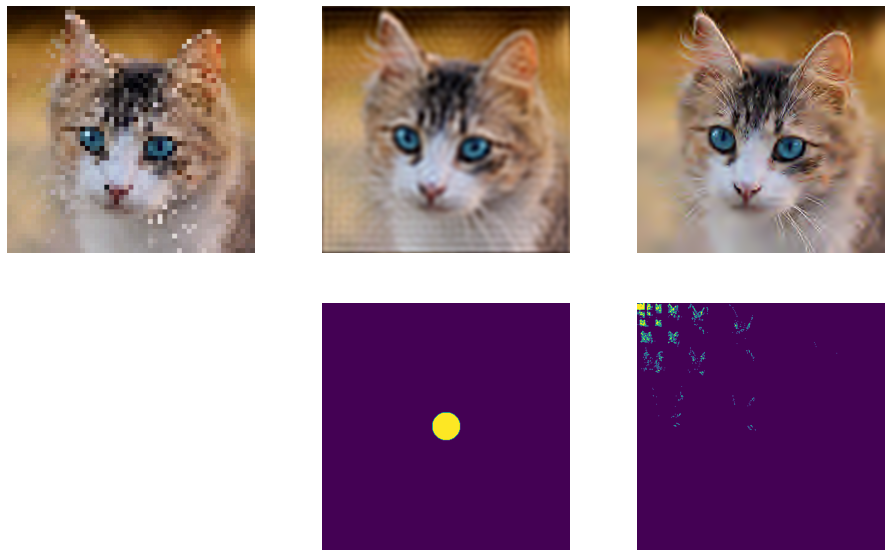

In [9]:
r = .01 # compression ratio
render_display(r)

### Interactive Plot

In [10]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [11]:
@interact(r=(0.01/2,0.1,0.01/2))
def h(r=.05):
    render_display(r)

interactive(children=(FloatSlider(value=0.05, description='r', max=0.1, min=0.005, step=0.005), Output()), _do…

----
## A Deeper Look at Fourier and Wavelets

In [12]:
from __future__ import division

import numpy as np
import scipy as scp
import pylab as pyl
import matplotlib.pyplot as plt

from nt_toolbox.general import *
from nt_toolbox.signal import *

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Signal to Noise Ratio (SNR) 
*Note:* to measure the error of an image $f$ with its
approximation $f_M$, we use the SNR measure, defined as

$$ \text{SNR}(f,f_M) = -20\log_{10} \pa{ \frac{ \norm{f-f_M} }{ \norm{f} } },  $$

which is a quantity expressed in decibels (dB).
The higer the SNR, the better the quality.


### Image Loading and Displaying


First we load an image $ f \in \RR^N $ of $ N = N_0 \times N_0 $ pixels.

In [13]:
n0 = 512
f = rescale(load_image("nt_toolbox/data/hibiscus.bmp", n0))

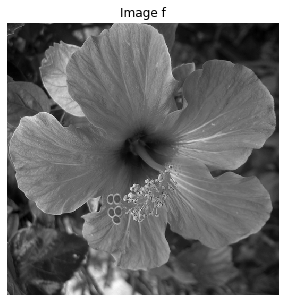

In [14]:
plt.figure(figsize = (5,5))
imageplot(f, 'Image f')

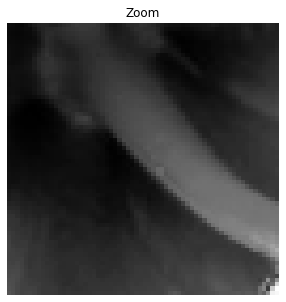

In [15]:
plt.figure(figsize = (5,5))
imageplot(f[n0//2 - 32:n0//2 + 32,n0//2 - 32:n0//2 + 32], 'Zoom')

An image is a 2D array, it can be modified as a matrix.

In [16]:
?imageplot

Signature: imageplot(f, str='', sbpt=[])
Docstring: Use nearest neighbor interpolation for the display.
File:      ~/Documents/MLJC_Projects/Symmetries/nt_toolbox/signal.py
Type:      function


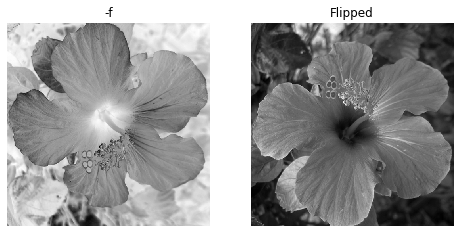

In [17]:
plt.figure(figsize = (8,8))
imageplot(-f, '-f', [1, 2, 1])
imageplot(f[::-1,], 'Flipped', [1, 2, 2])

Blurring is achieved by computing a convolution $f \star h$ with a kernel $h$.


Compute the low pass kernel.

In [18]:
k = 9; #size of the kernel
h = np.ones([k,k])
h = h/np.sum(h) #normalize

Compute the convolution $f \star h$.

In [19]:
from scipy import signal
fh = signal.convolve2d(f, h, boundary = "symm")

In [24]:
fh.shape

(520, 520)

In [23]:
#help(signal.convolve2d)

Display.

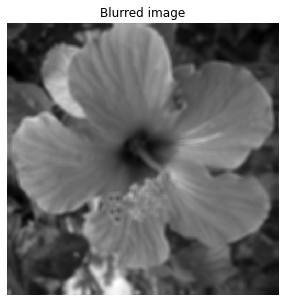

In [20]:
plt.figure(figsize = (5,5))
imageplot(fh, 'Blurred image')

Fourier Transform
-----------------
The Fourier orthonormal basis is defined as
$$ \psi_m(k) = \frac{1}{\sqrt{N}}e^{\frac{2i\pi}{N_0} \dotp{m}{k} } $$
where $0 \leq k_1,k_2 < N_0$ are position indexes,
and $0 \leq m_1,m_2 < N_0$ are frequency indexes.


The Fourier transform $\hat f$ is the projection of the image on this Fourier
basis

$$ \hat f(m) = \dotp{f}{\psi_m}. $$


The Fourier transform is computed in $ O(N \log(N)) $ operation using the FFT algorithm
(Fast Fourier Transform).
Note the normalization by $\sqrt{N}=N_0$ to make the transform orthonormal.

In [26]:
F = pyl.fft2(f)/n0

We check on the conservation of the energy.

In [27]:
from pylab import linalg

print("Energy of Image:   %f" %linalg.norm(f))
print("Energy of Fourier: %f" %linalg.norm(F))

Energy of Image:   205.747421
Energy of Fourier: 205.747421


Compute the logarithm of the Fourier magnitude $ \log\left(\abs{\hat f(m)} +
\epsilon\right) $, for some small $\epsilon$.

In [28]:
L = pyl.fftshift(np.log(abs(F) + 1e-1))

In [33]:
I_F = pyl.fftshift(np.abs(F))

Display. Note that we use the function fftshift to put the 0 low frequency in the
middle.

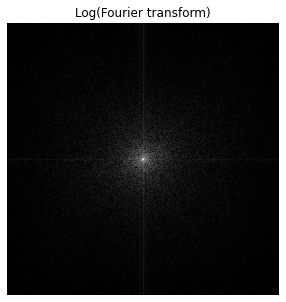

In [32]:
plt.figure(figsize = (5,5))
imageplot(L, 'Log(Fourier transform)')

Linear Fourier Approximation
----------------------------
An approximation is obtained by retaining a certain set of index $I_M$

$$ f_M = \sum_{ m \in I_M } \dotp{f}{\psi_m} \psi_m. $$


Linear approximation is obtained by retaining a *fixed* set $I_M$
of $M = \abs{I_M}$ coefficients. The important point is that $I_M$
does not depend on the image $f$ to be approximated.


For the Fourier transform, a low pass linear approximation
is obtained by keeping only the frequencies within a square.

$$ I_M = \enscond{m=(m_1,m_2)}{ -q/2 \leq m_1,m_2 < q/2 } $$
where $ q = \sqrt{M} $.


This can be achieved by computing the Fourier transform,
setting to zero the $N-M$ coefficients outside the square $I_M$
and then inverting the Fourier transform.


Number $M$ of kept coefficients.

In [13]:
M = n0**2//64

__Exercise 1__

Perform the linear Fourier approximation with $M$ coefficients.
Store the result in the variable $f_M$.

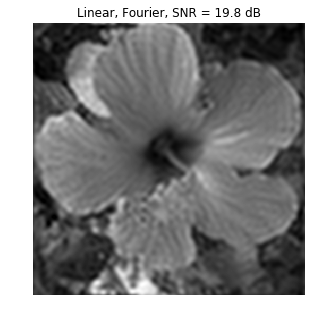

In [14]:
run -i nt_solutions/introduction_4_fourier_wavelets/exo1

In [15]:
## Insert your code here.

Compare two 1D profile (lines of the image).
This shows the strong ringing artifact of the linea approximation.

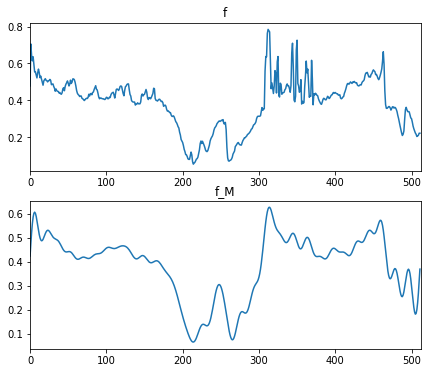

In [16]:
plt.figure(figsize=(7,6))

plt.subplot(2, 1, 1)
plt.plot(f[: , n0//2])
plt.xlim(0,n0)
plt.title('f')

plt.subplot(2, 1, 2)
plt.plot(fM[: , n0//2])
plt.xlim(0,n0)
plt.title('f_M')

plt.show()

Non-linear Fourier Approximation
--------------------------------
Non-linear approximation is obtained by keeping the $M$ largest
coefficients. This is equivalently computed using a thresholding of the
coefficients
$$ I_M = \enscond{m}{ \abs{\dotp{f}{\psi_m}}>T }. $$


Set a threshold $T>0$.

In [17]:
T = .2

Compute the Fourier transform.

In [18]:
F = pyl.fft2(f)/n0

Do the hard thresholding.

In [19]:
FT = np.multiply(F,(abs(F) > T))

Display. Note that we use the function fftshift to put the 0 low frequency in the
middle.

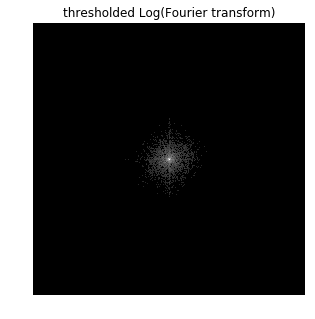

In [20]:
L = pyl.fftshift(np.log(abs(FT) + 1e-1))
plt.figure(figsize = (5,5))
imageplot(L, 'thresholded Log(Fourier transform)')

Inverse Fourier transform to obtain $f_M$.

In [21]:
fM = np.real(pyl.ifft2(FT)*n0)

Display.

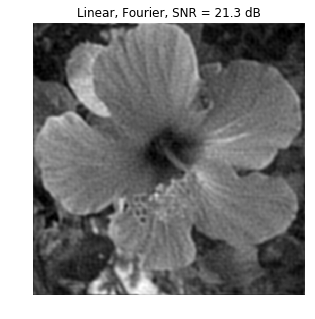

In [22]:
plt.figure(figsize = (5,5))
imageplot(clamp(fM), "Linear, Fourier, SNR = %.1f dB" %snr(f, fM))

Given a $T$, the number of coefficients is obtained by counting the
non-thresholded coefficients $ \abs{I_M} $.

In [23]:
m = np.sum(FT != 0)
print('M/N = 1/%d'  %(n0**2/m))

M/N = 1/53


__Exercise 2__

Compute the value of the threshold $T$ so that the number of
coefficients is $M$. Display the corresponding approximation
$f_M$.

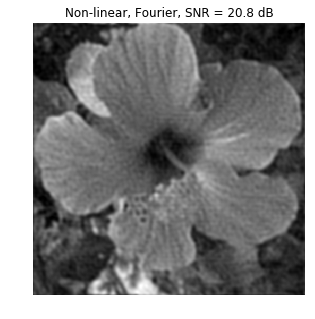

In [24]:
run -i nt_solutions/introduction_4_fourier_wavelets/exo2

In [25]:
## Insert your code here.

Wavelet Transform
-----------------
A wavelet basis $ \Bb = \{ \psi_m \}_m $
is obtained over the continuous domain by translating and
dilating three mother wavelet functions $ \{\psi^V,\psi^H,\psi^D\} $.


Each wavelet atom is defined as
$$ \psi_m(x) = \psi_{j,n}^k(x) = \frac{1}{2^j}\psi^k\pa{ \frac{x-2^j n}{2^j} } $$

The scale (size of the support) is $2^j$ and the position is
$2^j(n_1,n_2)$. The index is $ m=(k,j,n) $ for $\{ j \leq 0 \}$.


The wavelet transform computes all the inner products
$ \{ \dotp{f}{\psi_{j,n}^k} \}_{k,j,n} $.


Set the minimum scale for the transform to be 0.

In [26]:
Jmin = 0

Perform the wavelet transform,  $f_w$ stores all the wavelet coefficients.

In [27]:
from nt_toolbox.perform_wavelet_transf import *

fw = perform_wavelet_transf(f, Jmin, + 1)

Display the transformed coefficients.

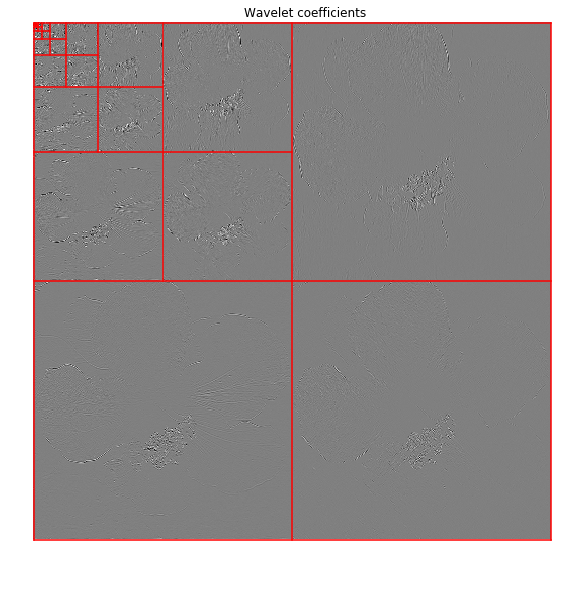

In [29]:
plt.figure(figsize=(10,10))

plot_wavelet(fw)
plt.title('Wavelet coefficients')

plt.show()

Wavelet Approximation
---------------------
Linear wavelet approximation with $M=2^{-j_0}$ coefficients is obtained
by keeping only the coarse scale (large support) wavelets:

$$ I_M = \enscond{(k,j,n)}{ j \geq j_0 }. $$


It corresponds to setting to zero all the coefficients excepted those
that are on the upper left corner of $f_w$.

__Exercise 3__

Perform linear approximation with $M$ wavelet coefficients.

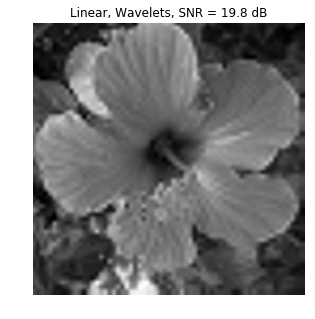

In [36]:
run -i nt_solutions/introduction_4_fourier_wavelets/exo3

In [37]:
## Insert your code here.

A non-linear approximation is obtained by keeping the $M$ largest wavelet
coefficients.


As already said, this is equivalently computed by a non-linear hard
thresholding.


Select a threshold.

In [38]:
T = .15

Perform hard thresholding.

In [39]:
fwT = np.multiply(fw,(abs(fw) > T))

Display the thresholded coefficients.

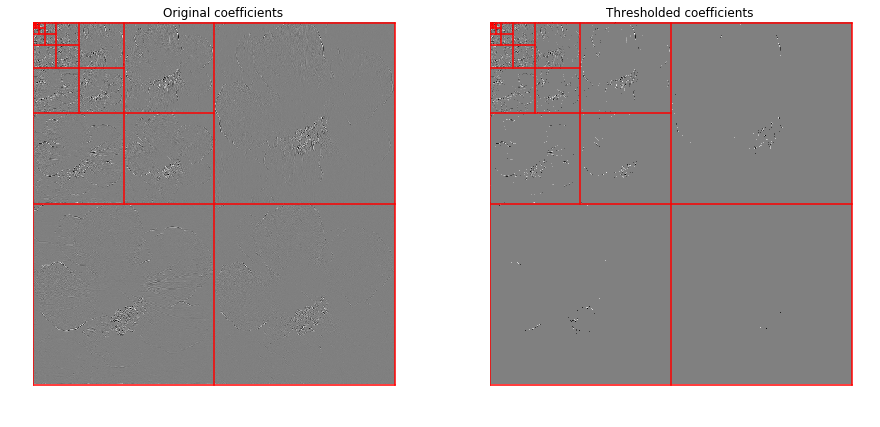

In [40]:
plt.figure(figsize=(15,15))

plt.subplot(1, 2, 1)
plot_wavelet(fw)
plt.title('Original coefficients')

plt.subplot(1, 2, 2)
plot_wavelet(fwT)
plt.title('Thresholded coefficients')

plt.show()

Perform reconstruction.

In [41]:
fM = perform_wavelet_transf(fwT, Jmin, -1)

Display approximation.

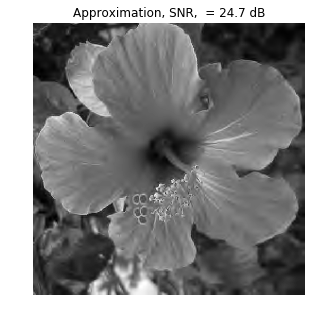

In [42]:
plt.figure(figsize=(5,5))
imageplot(clamp(fM), "Approximation, SNR,  = %.1f dB" %snr(f, fM))

__Exercise 4__

Perform non-linear approximation with $M$ wavelet coefficients by
chosing the correct value for $T$. Store the result in the variable
$f_M$.

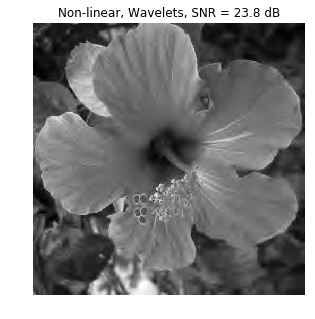

In [43]:
run -i nt_solutions/introduction_4_fourier_wavelets/exo4

In [44]:
## Insert your code here.

Compare two 1D profile (lines of the image).
Note how the ringing artifacts are reduced compared to the Fourier
approximation.

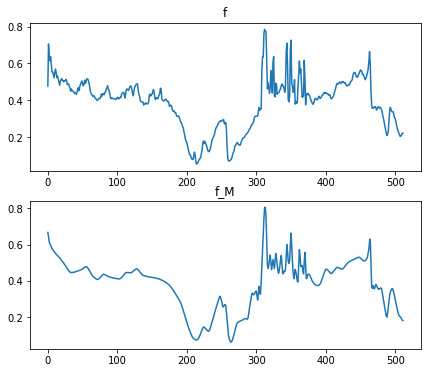

In [45]:
plt.figure(figsize=(7,6))

plt.subplot(2, 1, 1)
plt.plot(f[:,n0//2])
plt.title('f')

plt.subplot(2, 1, 2)
plt.plot(fM[:,n0//2])
plt.title('f_M')

plt.show()